In [1]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, get_analytes,
                                    load_data, count_spectra_by_analytes, get_tax_orders_lookup_tbl)
from spectrai.vis.spectra import (plot_spectra)
import pandas as pd
import altair as alt

from spectrai.features.preprocessing import TakeDerivative
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import time

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
%%time
# Loading Clay
X, X_names, y, y_names, instances_id = load_data(analytes=[334])

CPU times: user 23.4 s, sys: 4.63 s, total: 28 s
Wall time: 28.7 s


In [4]:
X.shape

(47014, 1764)

In [5]:
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))

X approx. memory size: 331 MB


In [6]:
y.shape

(47014, 3)

In [7]:
y_names

array(['lay_depth_to_top', 'order_id', 'calc_value'], dtype=object)

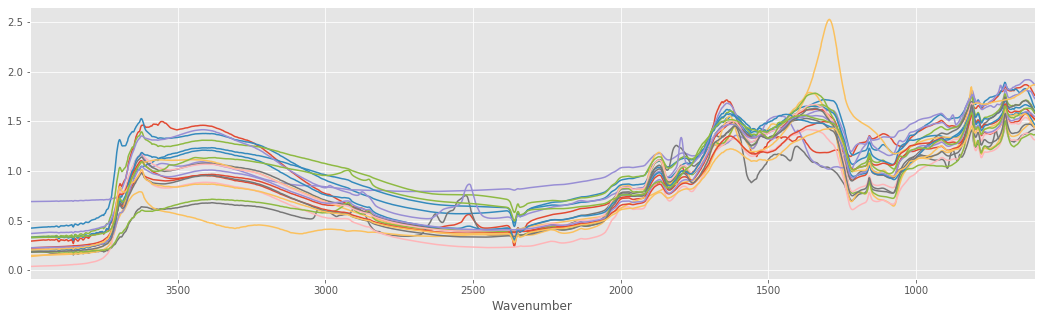

In [8]:
# Quick plot of some spectra
plot_spectra(X, X_names, sample=20)

In [9]:
 get_tax_orders_lookup_tbl()

{'alfisols': 0,
 'mollisols': 1,
 'inceptisols': 2,
 'entisols': 3,
 'spodosols': 4,
 nan: 5,
 'ultisols': 6,
 'andisols': 7,
 'histosols': 8,
 'oxisols': 9,
 'vertisols': 10,
 'aridisols': 11,
 'gelisols': 12}

(array([4.6113e+04, 7.9800e+02, 3.6000e+01, 1.9000e+01, 1.4000e+01,
        1.0000e+01, 7.0000e+00, 8.0000e+00, 5.0000e+00, 4.0000e+00]),
 array([   0. ,  173.7,  347.4,  521.1,  694.8,  868.5, 1042.2, 1215.9,
        1389.6, 1563.3, 1737. ]),
 <a list of 10 Patch objects>)

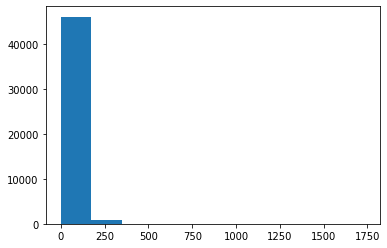

In [10]:
import matplotlib.pyplot as plt
plt.hist(y[:,0])

### EDA

In [11]:
y_names

array(['lay_depth_to_top', 'order_id', 'calc_value'], dtype=object)

In [12]:
# Convert to pandas
df_y = pd.DataFrame(y, columns=y_names)
df_y = df_y.astype({'order_id': 'int32'})
df_y.head()

lay_depth_to_top  order_id  calc_value
0              50.0        10   40.369179
1              74.0         1   33.247584
2              30.0        10   58.578392
3              60.0         4    2.236891
4              98.0         2   50.404355

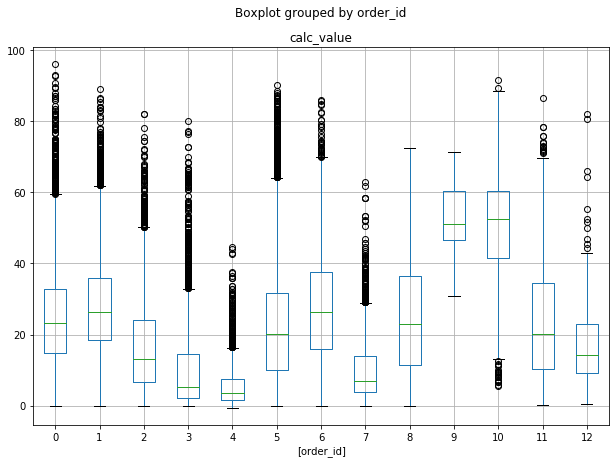

In [13]:
df_y.boxplot(column=['calc_value'], by=['order_id'], figsize=(10, 7));

In [14]:
y_names

array(['lay_depth_to_top', 'order_id', 'calc_value'], dtype=object)

In [15]:
alt.data_transformers.disable_max_rows()
WIDTH = 860
points = alt.Chart(df_y).mark_point(
    filled=True,
    color='steelblue',
    size=80
).encode(
    x=alt.X('median(calc_value)', title='Clay content'),
    y=alt.Y(
        'order_id:N',
         sort=alt.EncodingSortField(
             field='calc_value',
             op='median',
             order='ascending'
         ),
        title='Taxonomic order'
    )
).properties(
    width=0.6*WIDTH,
    height=300,
    title='Q1 (first quartile) ----- Median (point) ----- Q3 (third quartile)'
)

error_bars = points.mark_rule(size=1.5, color='steelblue').encode(
    x='q1(calc_value)',
    x2='q3(calc_value)',
)

chart1 = (points + error_bars)
chart1

alt.LayerChart(...)

In [16]:
df_y_barchart = df_y.groupby('order_id')['calc_value'] \
    .agg(['size', 'median']) \
    .sort_values(by='median', ascending=False) \
    .reset_index()

df_y_barchart

order_id   size     median
0         10    796  52.478568
1          9     23  51.027810
2          1  10520  26.450436
3          6   2825  26.208435
4          0   5276  23.102941
5          8    562  22.961208
6         11   1535  20.130578
7          5  15401  20.010298
8         12    416  14.103175
9          2   4206  13.239040
10         7   1295   6.878967
11         3   2395   5.097428
12         4   1764   3.593967

In [17]:
bars = alt.Chart(df_y_barchart).mark_bar(size=15).encode(
    x=alt.X(
        'size:Q',
        title='# of samples'),
    y=alt.Y(
        'order_id:N',
         sort=alt.EncodingSortField(
             field='median',
             order='ascending'
         ),
        title=''
    )
).properties(
    width=0.3*WIDTH,
    height=300
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='size'
)

chart2 = (bars + text)
chart2

alt.LayerChart(...)

In [18]:
(chart1 | chart2) \
    .configure_axis(
        labelFontSize=11,\
        titleFontSize=13,\
        gridDash=[4,4]) \
    .configure_title(
        fontSize=13
    )

alt.HConcatChart(...)

### Predict on Mollisols (1)

In [19]:
# Keeping data with analyte concentration > 0 only and for 'alfisols' taxonomic order only.
TAX_ORDER_ID = 1

idx_y_valid = y[:, -1] > 0
idx_order = y[:,1] == TAX_ORDER_ID
idx = idx_y_valid & idx_order

X_subset = X[idx,:]
y_subset = y[idx,:]

In [20]:
# Creating train, valid, test sets
# By default it shuffles the dataset
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset[:, -1], test_size=0.20, random_state=42)

print('X train shape: ', X_train.shape)
print('X test shape: ', X_test.shape)
print('y train shape: ', y_train.shape)
print('y test shape: ', y_test.shape)

X train shape:  (8406, 1764)
X test shape:  (2102, 1764)
y train shape:  (8406,)
y test shape:  (2102,)


In [76]:
training_size = [50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, X_train.shape[0]]
training_size

[50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8406]

In [77]:
for size in training_size:
    print(X_train[:size, :].shape)

(50, 1764)
(100, 1764)
(500, 1764)
(1000, 1764)
(2000, 1764)
(3000, 1764)
(4000, 1764)
(5000, 1764)
(6000, 1764)
(7000, 1764)
(8406, 1764)


In [75]:
X_train[:8406,:].shape

(8406, 1764)

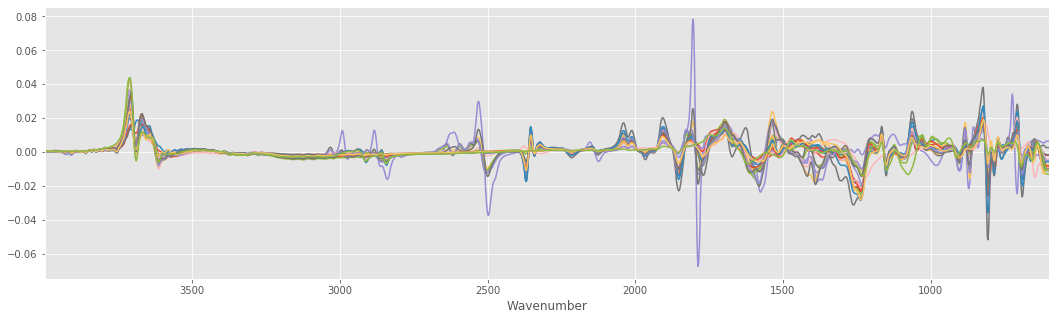

In [83]:
derivative = TakeDerivative(window_length=11, polyorder=1, deriv=1)
plot_spectra(derivative.fit_transform(X_train), X_names, sample=20)

In [202]:
def plot_validation_curve(train_score, valid_score, x_labels, x_labels_name):
    max_val_score = np.max(valid_score)
    max_hyperparam = x_labels[np.argmax(valid_score)]
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x_labels, train_score, marker = '.', markersize=10, label='Training')
    ax.plot(x_labels, valid_score, marker = '.', markersize=10, label='Validation')
    ax.set(title='Validation Curve', ylabel=r'$R^2$', xlabel=x_labels_name)
    ax.legend()

* **PLS valid & learning curve**

In [236]:
# Set grid of hyper-parameters values to explore
#param_grid = {'deriv__window_length': range(3, 9, 2), # Should be odd
#              'deriv__polyorder': range(1, 2),
#              'model__n_components': range(2,20)}

pls_components = range(2, 30)
training_size = [50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, X_train.shape[0]]
#training_size = [50, 100, 150, 200]

param_grid = {'model__n_components': pls_components}

--------------------------------------------------
# of training sample: 50
Best Valid. score: 0.40
Best hyperparameter(s) value: {'model__n_components': 3}
Test score: 0.62
Computation time: 3.25s
--------------------------------------------------


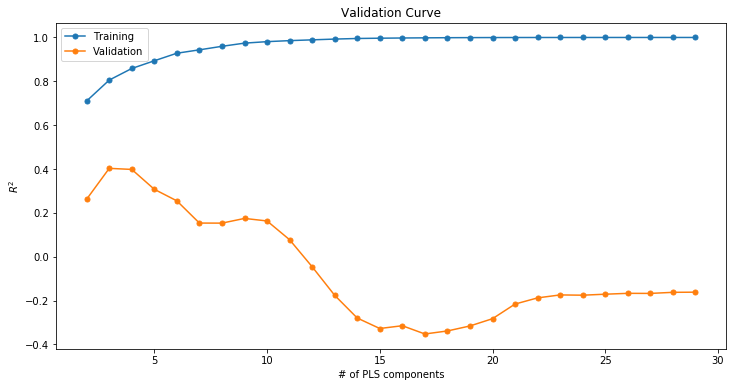

--------------------------------------------------
# of training sample: 100
Best Valid. score: 0.72
Best hyperparameter(s) value: {'model__n_components': 17}
Test score: 0.68
Computation time: 4.27s
--------------------------------------------------


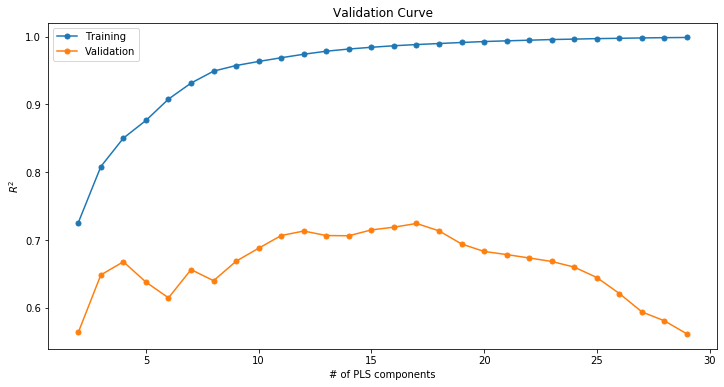

--------------------------------------------------
# of training sample: 500
Best Valid. score: 0.86
Best hyperparameter(s) value: {'model__n_components': 17}
Test score: 0.82
Computation time: 14.95s
--------------------------------------------------


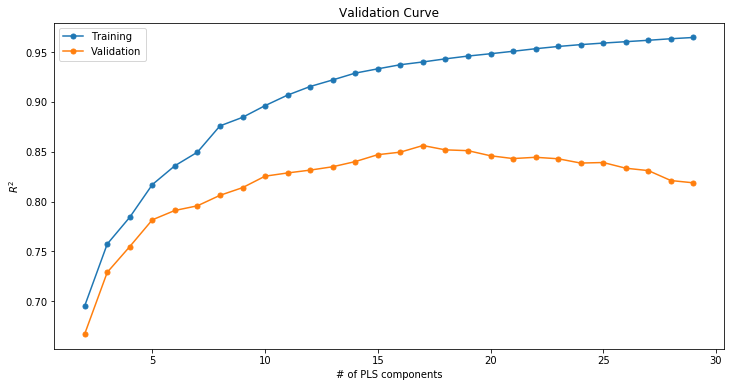

--------------------------------------------------
# of training sample: 1000
Best Valid. score: 0.85
Best hyperparameter(s) value: {'model__n_components': 19}
Test score: 0.85
Computation time: 31.07s
--------------------------------------------------


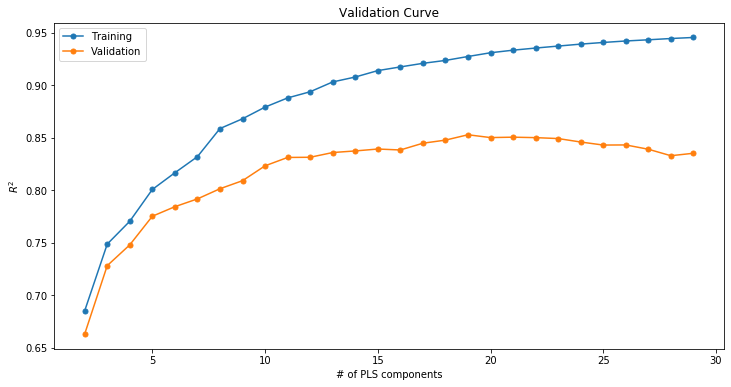

--------------------------------------------------
# of training sample: 2000
Best Valid. score: 0.89
Best hyperparameter(s) value: {'model__n_components': 29}
Test score: 0.88
Computation time: 62.24s
--------------------------------------------------


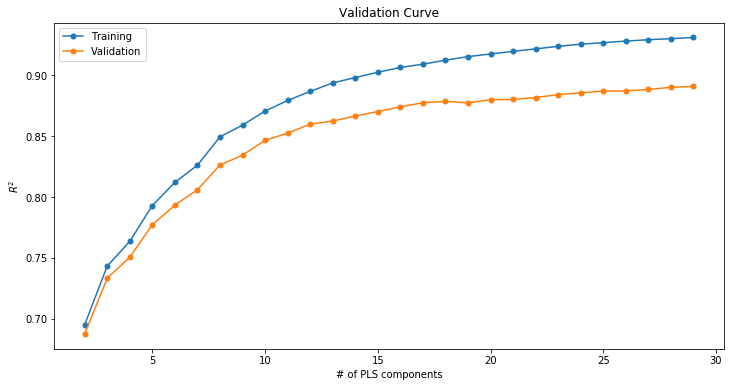

--------------------------------------------------
# of training sample: 3000
Best Valid. score: 0.90
Best hyperparameter(s) value: {'model__n_components': 24}
Test score: 0.89
Computation time: 90.50s
--------------------------------------------------


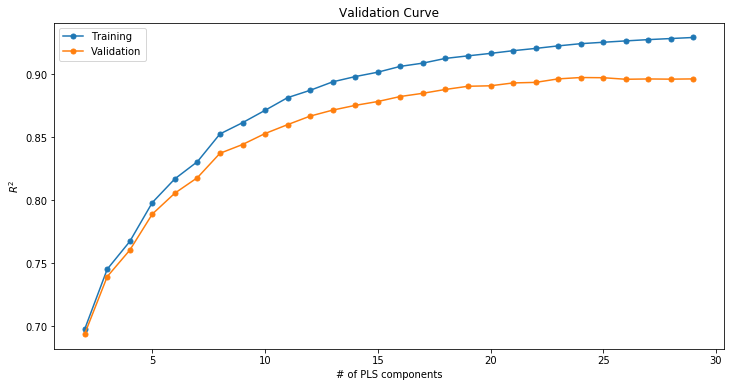

--------------------------------------------------
# of training sample: 4000
Best Valid. score: 0.90
Best hyperparameter(s) value: {'model__n_components': 25}
Test score: 0.89
Computation time: 134.61s
--------------------------------------------------


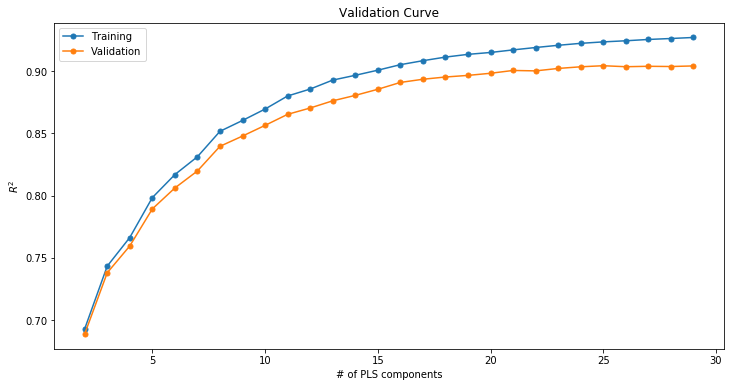

--------------------------------------------------
# of training sample: 5000
Best Valid. score: 0.90
Best hyperparameter(s) value: {'model__n_components': 29}
Test score: 0.90
Computation time: 150.76s
--------------------------------------------------


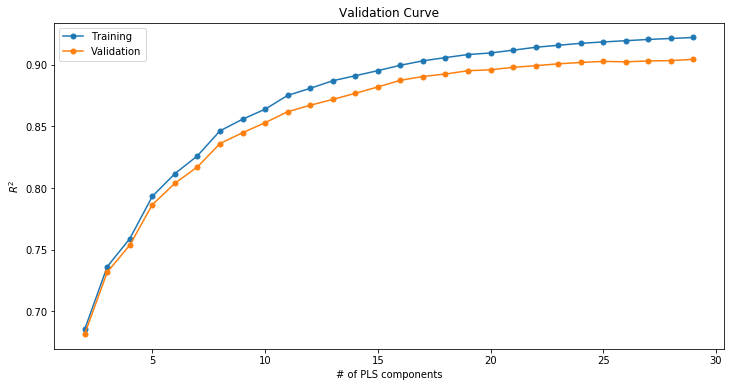

--------------------------------------------------
# of training sample: 6000
Best Valid. score: 0.91
Best hyperparameter(s) value: {'model__n_components': 29}
Test score: 0.90
Computation time: 172.09s
--------------------------------------------------


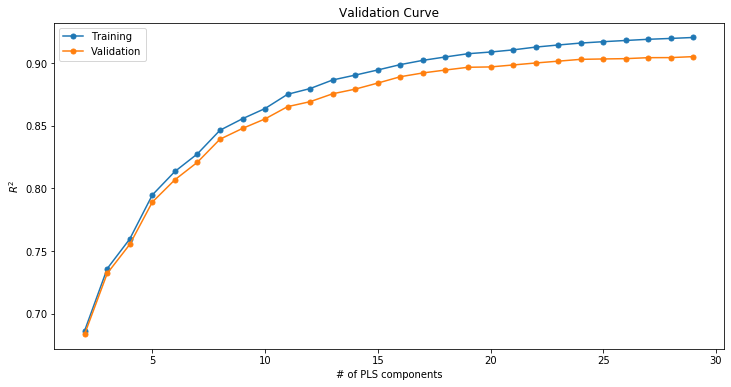

--------------------------------------------------
# of training sample: 7000
Best Valid. score: 0.91
Best hyperparameter(s) value: {'model__n_components': 29}
Test score: 0.90
Computation time: 198.23s
--------------------------------------------------


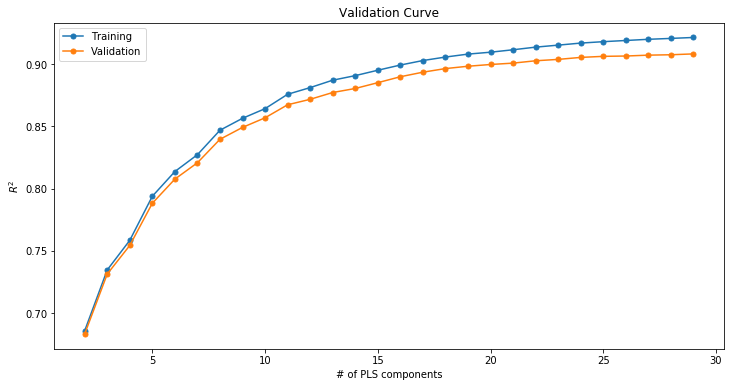

--------------------------------------------------
# of training sample: 8406
Best Valid. score: 0.91
Best hyperparameter(s) value: {'model__n_components': 29}
Test score: 0.90
Computation time: 273.24s
--------------------------------------------------


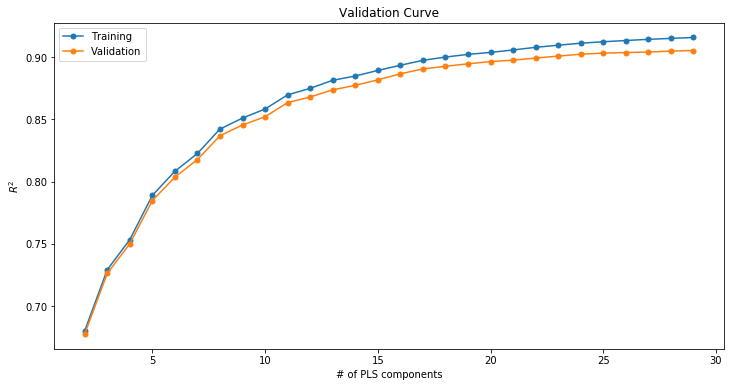

In [237]:
history = {'nb_samples': [], 'train_score': [], 'valid_score': [], 'best_params': []}

for size in training_size:
    start = time.time()
    
    # Setup and fit the pipeline
    pipe = Pipeline([('deriv', TakeDerivative()), ('model', PLSRegression())])
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', return_train_score=True, verbose=0)
    grid_search.fit(X_train[:size, :], y_train[:size])
    
    history['nb_samples'].append(size)
    history['train_score'].append(grid_search.best_estimator_.score(X_train[:size, :], y_train[:size]))
    history['valid_score'].append(grid_search.best_score_)
    history['best_params'].append(grid_search.best_params_)

    end = time.time()
    print(50*'-')
    print('# of training sample: {}'.format(size))
    print('Best Valid. score: {:.2f}'.format(grid_search.best_score_))
    print('Best hyperparameter(s) value: {}'.format(grid_search.best_params_))
    print('Test score: {:.2f}'.format(grid_search.best_estimator_.score(X_test, y_test)))
    print('Computation time: {:.2f}s'.format(end - start))
    print(50*'-')
    plot_validation_curve(grid_search.cv_results_['mean_train_score'],  
                          grid_search.cv_results_['mean_test_score'],
                          pls_components, '# of PLS components')
    plt.show()

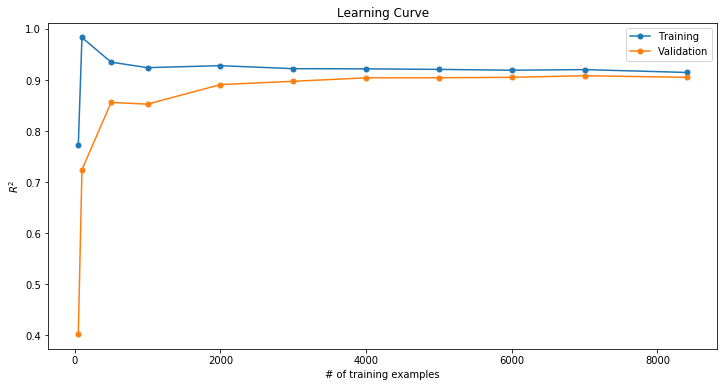

In [238]:
def plot_learning_curve(history):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(history['nb_samples'], history['train_score'], marker = '.', markersize=10, label='Training')
    ax.plot(history['nb_samples'], history['valid_score'], marker = '.', markersize=10, label='Validation')
    ax.set(title='Learning Curve', ylabel=r'$R^2$', xlabel="# of training examples")
    ax.legend()
    
plot_learning_curve(history)

* **RF valid & learning curve**

In [129]:
# Quick try to find sensible hyperparams
#     - n_estimators: # of trees in the forest
#     - max_samples: (if float bewteen 0 and 1) percentage of training sample for each tree (sampled with replacement -bootstrap by default)
#     - max_features: (if float bewteen 0 and 1) percentage of features sampled for each tree
#     - max_depth: maximum depth of the tree
rf_model = RandomForestRegressor(n_estimators=100, max_samples=0.5, max_features=0.5, max_depth=10, random_state=42)
#rf_model = RandomForestRegressor(n_estimators=100, max_samples=0.5, max_features=0.5, max_leaf_nodes=16, random_state=42)

In [130]:
X_train.shape

(8406, 1764)

In [131]:
training_size=10000

In [132]:
%%time
rf_model.fit(X_train[:training_size,:], y_train[:training_size])

CPU times: user 3min 37s, sys: 172 ms, total: 3min 37s
Wall time: 3min 37s


RandomForestRegressor(max_depth=10, max_features=0.5, max_samples=0.5,
                      random_state=42)

In [133]:
rf_model.score(X_train, y_train)

0.8912818511294325

In [134]:
rf_model.score(X_test, y_test)

0.8182216817922008

In [124]:
rf_model.feature_importances_

array([0.00156084, 0.00100346, 0.00095219, ..., 0.00265906, 0.00144505,
       0.0012647 ])

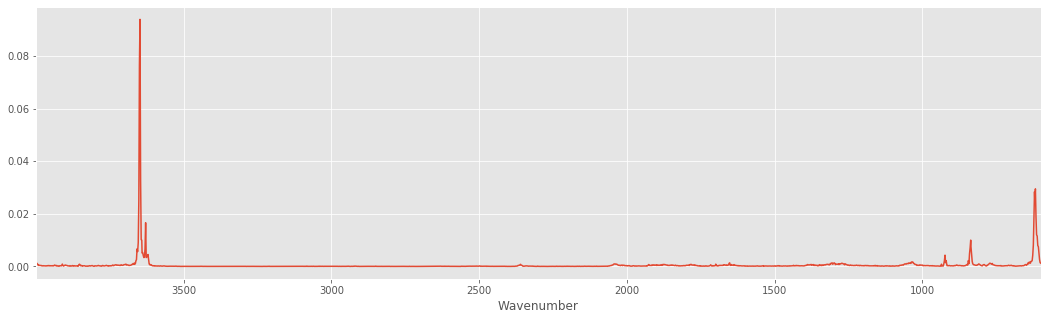

In [128]:
def plot_features_importance(feat_importance, X_names, figsize=(18, 5)):
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_xlim(np.max(X_names), np.min(X_names))
        plt.xlabel('Wavenumber')
        _ = ax.plot(X_names, feat_importance)
        
plot_features_importance(rf_model.feature_importances_, X_names)

In [ ]:
# Set grid of hyper-parameters values to explore
#param_grid = {'deriv__window_length': range(3, 9, 2), # Should be odd
#              'deriv__polyorder': range(1, 2),
#              'model__n_components': range(2,20)}

pls_components = range(2, 30)
training_size = [50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, X_train.shape[0]]
#training_size = [50, 100, 150, 200]

param_grid = {'model__n_components': pls_components}

In [ ]:
history = {'nb_samples': [], 'train_score': [], 'valid_score': [], 'best_params': []}

for size in training_size:
    start = time.time()
    
    # Setup and fit the pipeline
    pipe = Pipeline([('deriv', TakeDerivative()), ('model', PLSRegression())])
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', return_train_score=True, verbose=0)
    grid_search.fit(X_train[:size, :], y_train[:size])
    
    history['nb_samples'].append(size)
    history['train_score'].append(grid_search.best_estimator_.score(X_train[:size, :], y_train[:size]))
    history['valid_score'].append(grid_search.best_score_)
    history['best_params'].append(grid_search.best_params_)

    end = time.time()
    print(50*'-')
    print('# of training sample: {}'.format(size))
    print('Best Valid. score: {:.2f}'.format(grid_search.best_score_))
    print('Best hyperparameter(s) value: {}'.format(grid_search.best_params_))
    print('Test score: {:.2f}'.format(grid_search.best_estimator_.score(X_test, y_test)))
    print('Computation time: {:.2f}s'.format(end - start))
    print(50*'-')
    plot_validation_curve(grid_search.cv_results_['mean_train_score'],  
                          grid_search.cv_results_['mean_test_score'],
                          pls_components, '# of PLS components')
    plt.show()